In [ ]:
!pip uninstall -y tensorflow numpy
!pip install numpy
!pip install tensorflow


In [3]:
# Weather Analysis and Prediction using Deep Learning


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings

# deep learning imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2


warnings.filterwarnings('ignore')

In [4]:
# pot style
sns.set(style="whitegrid", palette="muted", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


def weather_data_implement(file_path):
    """
    this method is collecting the data and loading it
    """
    try:
        # Load the data
        df = pd.read_csv(file_path)
        
        # Display basic info
        print(f"Dd.shape: {df.shape}")
        print(df.head())
        
        # df.columns -> data columns
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'])
            df.sort_values('date', inplace=True)
            df.reset_index(drop=True, inplace=True)
        elif 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.sort_values('datetime', inplace=True)
            df.reset_index(drop=True, inplace=True)
        
        #  -> solvingmissing values -> solving
        print(df.isnull().sum())
        
        # -> solving missing values -> solving
        numeric_cols = df.select_dtypes(include=np.number).columns
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
        
        df = df.dropna(axis=1, how='all')
        
        return df
    
    except Exception as e:
        print(f"Failure Data: {e}")
        return None

In [5]:

def eda_implement(df):
    """
    EDA anaylsis
    """
    print(df.describe())
    
    if 'date' in df.columns:
        df.set_index('date', inplace=True)
    elif 'datetime' in df.columns:
        df.set_index('datetime', inplace=True)
    
    if 'temperature' in df.columns:
        plt.figure(figsize=(15, 6))
        df['temperature'].plot(title='Temperature Value over Time')
        plt.ylabel('Temperature celusis (°C)')
        plt.show()
    
    if 'humidity' in df.columns:
        plt.figure(figsize=(15, 6))
        df['humidity'].plot(title='Humidityvalue over time', color='green')
        plt.ylabel('Humidity Value (%)')
        plt.show()
    
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    
    if 'temperature' in df.columns and 'hour' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='hour', y='temperature')
        plt.title('Temperature Distribution by Hour of Day')
        plt.show()
    
    if 'temperature' in df.columns and 'month' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='month', y='temperature')
        plt.title('Temperature Distribution by Month')
        plt.show()

    numeric_cols = df.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 1:
        plt.figure(figsize=(12, 10))
        sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Heatmap')
        plt.show()
    

    df.reset_index(inplace=True)



def features_form(df, target_col='temperature', lookback=24, forecast_horizon=12):

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    
    if target_col not in numeric_cols:
        raise ValueError(f"Target column '{target_col}' not found in numeric columns")
    
    features = [col for col in numeric_cols if col != target_col]
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[numeric_cols])
    
    X, y = [], []
    for i in range(lookback, len(df) - forecast_horizon):
        X.append(scaled_data[i-lookback:i, :-1]) 
        y.append(scaled_data[i+forecast_horizon, numeric_cols.index(target_col)])  
    
    return np.array(X), np.array(y), scaler


def lstm_model_form(input_shape):


    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape, 
             kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
        Dropout(0.3),
        LSTM(64, return_sequences=False, 
             kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def lstm_model_build(input_shape):

    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def model_build_and_train(model, X_train, y_train, X_test, y_test, model_name, epochs=50):

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'best_{model_name}.h5', save_best_only=True)
    ]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training History')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    return model, history

def model_solution(model, X_test, y_test, scaler, feature_names, target_index):
    """
    Evaluate model
    """
    
    #predictions
    y_pred = model.predict(X_test)
    
    #dummy array 
    dummy_array = np.zeros((len(y_test), len(feature_names)))
    dummy_array[:, target_index] = y_test.flatten()
    y_test_actual = scaler.inverse_transform(dummy_array)[:, target_index]
    
    dummy_array[:, target_index] = y_pred.flatten()
    y_pred_actual = scaler.inverse_transform(dummy_array)[:, target_index]
    
    #metrics
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    
  
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {np.sqrt(mse):.2f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_actual[:200], label='Actual', linewidth=2)
    plt.plot(y_pred_actual[:200], label='Predicted', alpha=0.8)
    plt.title('Actual vs Predicted Values (First 200 Samples)')
    plt.ylabel('Temperature (°C)')
    plt.xlabel('Time Steps')
    plt.legend()
    plt.show()
    
    return mse, mae

Loading local data file.
Dd.shape: (8760, 7)
              datetime  temperature  humidity     pressure  wind_speed  \
0  2020-01-01 00:00:00     7.153370        69  1012.086650    9.327891   
1  2020-01-01 01:00:00    13.504751        57  1009.676775    8.142695   
2  2020-01-01 02:00:00    15.204870        59  1020.313951    9.533399   
3  2020-01-01 03:00:00    16.907058        56  1009.957222   13.293502   
4  2020-01-01 04:00:00     8.620137        89  1021.515945    8.832202   

   wind_deg  cloud_cover  
0       290           26  
1       281           31  
2       312           94  
3         3           30  
4       325           75  
datetime       0
temperature    0
humidity       0
pressure       0
wind_speed     0
wind_deg       0
cloud_cover    0
dtype: int64
       temperature     humidity     pressure   wind_speed     wind_deg  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean     10.035937    59.497717  1014.963097     7.488524   178.5202

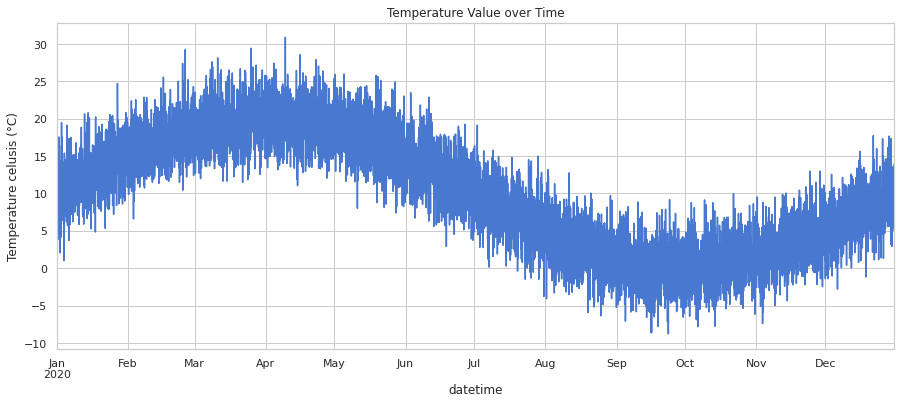

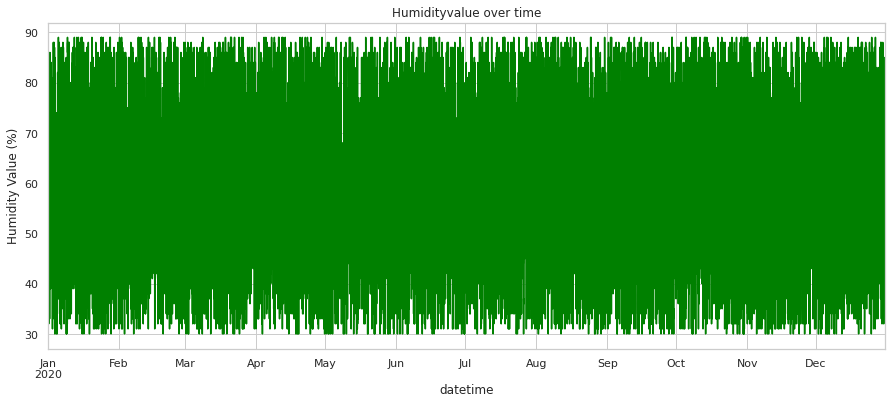

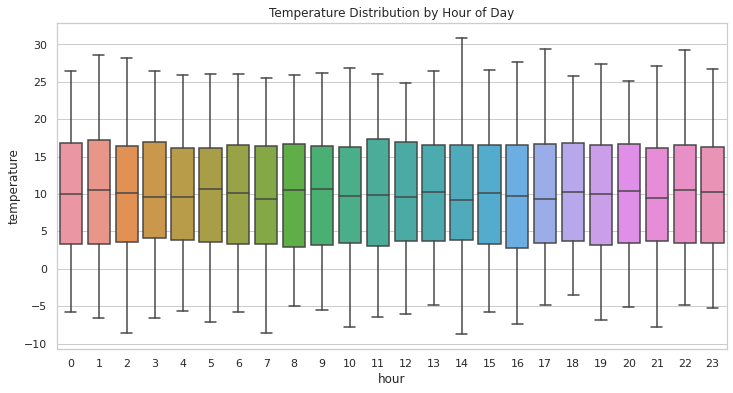

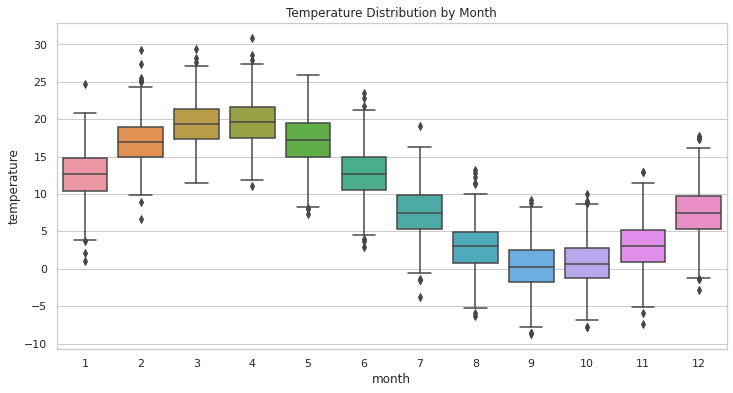

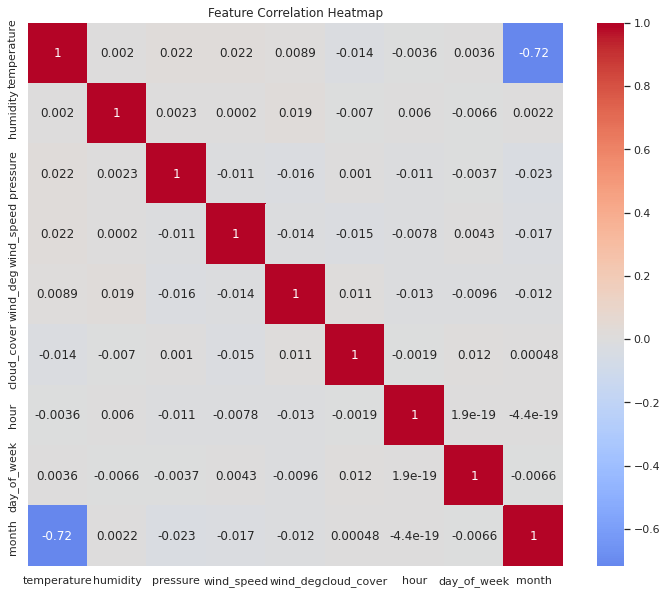

(6984, 24, 5) (6984, 24, 5)
(6984,) (6984,)
(1746, 24, 5) (1746, 24, 5)
(1746,) (1746,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           68608     
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                  

In [ ]:


def main():
    # Load data - URL or local file
    data_url = "https://raw.githubusercontent.com/yourusername/weather-data/main/weather_dataset.csv"
    local_file = "weather_data.csv"
    
    # Try to download data if local file doesn't exist
    if not os.path.exists(local_file):
        try:
            print(f"Data copy {data_url}")
            df = pd.read_csv(data_url)
            df.to_csv(local_file, index=False)
            print("Data copied and saved.")
        except:
            print("Data not copied.")
            dates = pd.date_range("2020-01-01", periods=365*24, freq='H')
            df = pd.DataFrame({
                'datetime': dates,
                'temperature': 10 + 10 * np.sin(2 * np.pi * np.arange(len(dates)) / (365*24)) + np.random.normal(0, 3, len(dates)),
                'humidity': np.random.randint(30, 90, len(dates)),
                'pressure': np.random.normal(1015, 5, len(dates)),
                'wind_speed': np.random.uniform(0, 15, len(dates)),
                'wind_deg': np.random.randint(0, 360, len(dates)),
                'cloud_cover': np.random.randint(0, 100, len(dates))
            })
            df.to_csv(local_file, index=False)
    else:
        print("Loading local data file.")
        df = pd.read_csv(local_file)
    
    #preprocess data
    weather_df = weather_data_implement(local_file)
    
    # EDA
    eda_implement(weather_df.copy())
    

    target_col = 'temperature' 
    lookback = 24 
    forecast_horizon = 6 
    
    X, y, scaler = features_form(
        weather_df, 
        target_col=target_col,
        lookback=lookback,
        forecast_horizon=forecast_horizon
    )
    
    numeric_cols = weather_df.select_dtypes(include=np.number).columns.tolist()
    target_index = numeric_cols.index(target_col)
    feature_names = [col for col in numeric_cols if col != target_col]
    
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    print(f"{X_train.shape} {X_train.shape}")
    print(f"{y_train.shape} {y_train.shape}")
    print(f"{X_test.shape} {X_test.shape}")
    print(f"{y_test.shape} {y_test.shape}")
    
    # model
    lstm_model = lstm_model_form((X_train.shape[1], X_train.shape[2]))
    lstm_model.summary()
    
    lstm_model, lstm_history = model_build_and_train(
        lstm_model, X_train, y_train, X_test, y_test, 'lstm_model', epochs=50
    )
    
    # LSTM model
    lstm_mse, lstm_mae = model_solution(
        lstm_model, X_test, y_test, scaler, numeric_cols, target_index
    )
    
    #Training LSTM model
    cnn_lstm_model = lstm_model_build((X_train.shape[1], X_train.shape[2]))
    cnn_lstm_model.summary()
    
    cnn_lstm_model, cnn_lstm_history = model_build_and_train(
        cnn_lstm_model, X_train, y_train, X_test, y_test, 'cnn_lstm_model', epochs=50
    )
    
    cnn_lstm_mse, cnn_lstm_mae = model_solution(
        cnn_lstm_model, X_test, y_test, scaler, numeric_cols, target_index
    )
    


    print(f" MSE: {lstm_mse:.2f}, MAE: {lstm_mae:.2f}")
    print(f": {cnn_lstm_mse:.2f}, MAE: {cnn_lstm_mae:.2f}")
    
    # Save models
    lstm_model.save('weather_lstm_model.h5')
    cnn_lstm_model.save('weather_cnn_lstm_model.h5')

if __name__ == "__main__":
    main()